## ライブラリのインポート 

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

## APIサーバのURLと認証キーを設定

In [2]:
scoring_uri = 'http://963664bf-001a-457d-866e-743afa597c1b.eastus.azurecontainer.io/score'
key = 'XIkOcRV12fD2cCsMc0H3VkikqhYTzPvA'

## Band Gap物性予測用のcsvファイルを取得する関数

In [3]:
def csv_to_list(csv_path):
    df = pd.read_csv(csv_path)
    features_list = df.drop('Band_gap', axis=1).values.tolist()
    target_list = df['Band_gap'].values.tolist()
    
    return target_list, features_list

## APIサーバに特徴量のリストを送信し、予測値のリストを返す関数

In [4]:
def get_predict(features_list, uri, key):
    features_dict = {"data": features_list}
    input_data = json.dumps(features_dict)
    headers = {'Content-Type': 'application/json'}
    headers['Authorization'] = f'Bearer {key}' 
    resp = requests.post(uri, input_data, headers=headers)
    result = resp.text
    predict_dict=json.loads(json.loads(result))
    return predict_dict["result"]

## テストデータの読み込み、テストデータについての予測

In [5]:
test_target, test_features = csv_to_list('BG_test.csv')
test_predict = get_predict(test_features, scoring_uri, key)

## 訓練データの読み込み、訓練データについての予測

In [ ]:
train_target, train_features = csv_to_list('BG_train.csv')
train_predict = get_predict(train_features, scoring_uri, key)

In [ ]:
print(len(test_predict))
print(len(train_target))

## 予測値 vs 実際の値

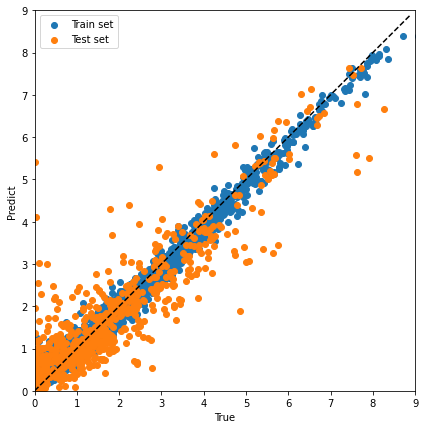

In [16]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(train_target, train_predict, label='Train set')
ax.scatter(test_target, test_predict, label='Test set')
ax.set_aspect('equal') 
x = np.arange(0, 9, 0.1)
y = x
plt.plot(x, y, c="black", linestyle="dashed")
plt.xlim(0,9)
plt.ylim(0,9)
plt.xlabel("True")
plt.ylabel("Predict")
plt.legend()
plt.show()

## Material projectからIDの材料データを取得する関数

In [17]:
def get_material_data(mpID):
    with MPRester(material_key, notify_db_version=False) as m:
        try:
            data = m.get_data(mpID)
        except Exception:
            print("error : %s" % mpID)
            exit()
    return data

## テスト材料をBand gap=2~3eVに含まれるか予測

In [20]:
true_test = [ (i > 2) & (i < 3) for i in test_target]
predict_test = [ (i > 2) & (i < 3) for i in test_predict]
positive=[]
f_negative=[]
for true, predict, features, bandgap in zip(true_test, predict_test, test_features, test_target):
    if predict:
        if true:
            correctness='〇'
        else:
            correctness='×'
        positive.append([features[0], features[1], features[2], bandgap, correctness])
    elif true and not(predict):
        f_negative.append([features[0], features[1], features[2], bandgap])
positive_df = pd.DataFrame(positive, columns=['ID', 'Formula', 'Space group', 'Band gap', 'Correctness'])
f_negative_df = pd.DataFrame(f_negative, columns=['ID', 'Formula', 'Space group', 'Band gap'])

## Band gap=2~3eVと予測された材料

In [21]:
positive_df

,ID,Formula,Space group,Band gap,Correctness
0,mvc-12404,Ti4O8,I4/m,2.5325,〇
1,mp-22897,Hg2Cl2,I4/mmm,2.8204,〇
2,mp-1021512,Lu4O12,Im-3,1.5999,×
3,mp-1190649,Mg12O12,Cm,2.7038,〇
4,mp-30954,Ga4I12,P2_1/c,2.3854,〇
...,...,...,...,...,...
104,mp-720,Tl4F4,Pbcm,3.2635,×
105,mp-583714,Pr40O72,P2_1/c,2.8314,〇
106,mp-765621,V4F20,P2_12_12_1,3.0717,×
107,mp-680294,Tl64Cl96,Pnma,1.7745,×


## Band gap=2~3eVだが、予測されなかった材料

In [22]:
f_negative_df

,ID,Formula,Space group,Band gap
0,mp-23261,I8O20,P2_1/c,2.7472
1,mp-867180,Pm4S6,R-3c,2.5717
2,mp-758601,Mn2F6,C2/m,2.7706
3,mp-568846,Ta8Br40,Pnma,2.0283
4,mp-11714,Si4C4,P6_3mc,2.3298
5,mp-1193977,Lu12S18,P6_3cm,2.4362
6,mp-643084,Gd6O9,C2/m,2.8556
7,mp-1588,C22F14,C2/m,2.2360
8,mvc-13985,Sn2F8,C2/c,2.4711
9,mp-766361,Nb20O50,P-1,2.1388


## Band gap=2~3eVの予測の混合行列

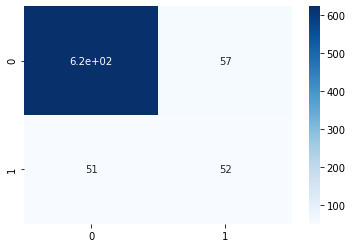

In [23]:
cm_test = confusion_matrix(true_test, predict_test)
sns.heatmap(cm_test, annot=True, cmap='Blues')
plt.show()